# Polynomial Surrogate Model

Consider a simple underlying function with Gaussian noise added to simulate experimental or noisy computational data.

$$y = 3x^2 + 2x + 1 + \mathcal{N}(0, \sigma), \text{ where } \sigma = 1$$

We will create the data at 20 points between $-2 \ldots 2$.

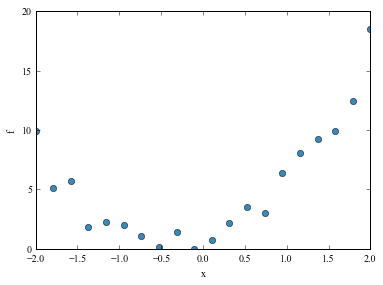

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

n = 20
sigma = 1.0
xdata = np.linspace(-2, 2, n)
fdata = 3*xdata**2 + 2*xdata + 1 + np.random.randn(n)*sigma

plt.figure()
plt.plot(xdata, fdata, 'o')
plt.xlabel('x')
plt.ylabel('f')
plt.show()

This data is our training data and consists of two pairs: $(x^{(i)}, f^{(i)})$.  Given this data, we want to compute a polynomial fit.  In this case, we know that it's quadratic, so let's use a quadratic model of the form:

$$\hat{f}(x) = a x^2 + b x + c$$

This is a simple least squares problem.

$$\text{minimize} \sum_i \left(\hat{f}(x^{(i)}) - f^{(i)} \right)^2 $$

Which we can rewrite in matrix form as:

$$\text{minimize} \; || \Psi w - f ||^2 $$

where

$$
\Psi = 
\begin{bmatrix}
\text{---} & \psi(x^{(1)})^T & \text{---} \\
\text{---} & \psi(x^{(2)})^T & \text{---} \\
& \vdots \\
\text{---} & \psi(x^{(n)})^T & \text{---} \\
\end{bmatrix}
$$

$$
f = \begin{bmatrix}
f^{(1)}\\
f^{(2)}\\
\vdots \\
f^{(n)}\\
\end{bmatrix}
$$

In our specific case: $w = [a, b, c]$ and $\psi = [x^2, x, 1]$.  The matrix equation can be solved as a least squares solution.  Notice that this simple form works in any number of dimensions (not just one). In higher dimensions we just add more terms to $\psi$.

In [3]:
Psi = np.zeros((n, 3))
Psi[:, 0] = xdata**2
Psi[:, 1] = xdata
Psi[:, 2] = 1

w, residuals, rank, s = np.linalg.lstsq(Psi, fdata)

print w

[ 2.95677362  2.08357032  0.82455735]


Ideally w would be [3, 2, 1] bsaed on our underlying polynomial, but it won't recover that exactly because of the noise in the function.

We now have a polynomial model: $\hat{f} = \Psi w$ that we can evaluate at any point.  Let's compute at many locations along the domain and compare out fit:

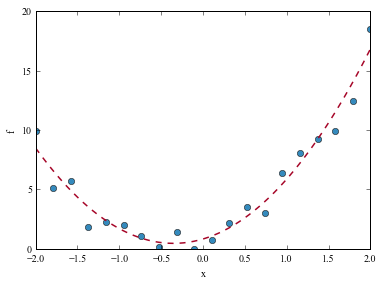

In [4]:
nfull = 200
xfull = np.linspace(-2, 2, nfull)
Psifull = np.zeros((nfull, 3))
Psifull[:, 0] = xfull**2
Psifull[:, 1] = xfull
Psifull[:, 2] = 1
ffull = np.dot(Psifull, w)

plt.figure()
plt.plot(xdata, fdata, 'o')
plt.plot(xfull, ffull, '--')
plt.xlabel('x')
plt.ylabel('f')
plt.show()

# Cross Validation

Let's consider another simple function with Gaussian noise:

$$f = (6x - 2)^2*\sin(12 x - 4) + \mathcal{N}(0, \sigma)$$

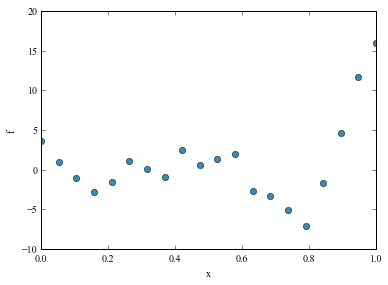

In [5]:
def func(x):
    sigma = 1.0
    return (6*x-2)**2*np.sin(12*x-4) + np.random.randn(len(x))*sigma


# ---- create training data ---------
ndata = 20
xdata = np.linspace(0, 1, ndata)
fdata = func(xdata)

plt.plot(xdata, fdata, 'o')
plt.xlabel('x')
plt.ylabel('f')
plt.show()

Visually, it's harder to determine what the best order for the polynomial is.  Of course, in higher dimensions we cannot visualize the function and so generally won't know beforehand what terms to use in our polynomial model.  We will use cross validation to help us choose an appropriate order.  Below, we create a function to create and evaluate a polynomial for any order (in a 1D space):

In [6]:
def getPsi(x, order):
    
    n = len(x)
    Psi = np.zeros((n, order+1))
    for i in range(order+1):
        Psi[:, i] = x**(order-i)
        
    return Psi


def createpoly(x, f, order):
    Psi = getPsi(x, order)
    w, residuals, rank, s = np.linalg.lstsq(Psi, f)

    return w


def evalpoly(x, w):
    order = len(w) - 1
    Psi = getPsi(x, order)
    f = np.dot(Psi, w)
    
    return f

Let's try different polynomial orders and check to see what the error is in our fit.

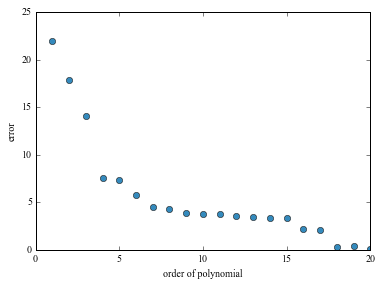

In [7]:
ordervec = np.arange(1, 21)
error = np.zeros(20)

for idx, order in enumerate(ordervec):

    # build a polynomial model from the training data 
    w = createpoly(xdata, fdata, order)

    # test the error 
    fhat = evalpoly(xdata, w)
    error[idx] = np.linalg.norm(fhat - fdata)


# plot error
plt.figure()
plt.plot(ordervec, error, 'o')
plt.xlabel('order of polynomial')
plt.ylabel('error')
plt.show()

This suggests that the higher the order of the polynomial the better!  Of course we know that's not true.  Let's look at what the polynomial model looks like in 20 dimensions:

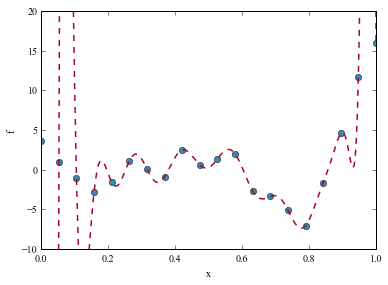

In [8]:
order = 20
w = createpoly(xdata, fdata, order)

nhat = 200
xhat = np.linspace(0, 1, nhat)
fhat = evalpoly(xhat, w)

plt.figure()
plt.plot(xdata, fdata, 'o')
plt.plot(xhat, fhat, '--')
plt.ylim([-10, 20])
plt.xlabel('x')
plt.ylabel('f')

We notice that the error at the points we are trying to fit is very small (which is what our least squares solution is doing), but the predictive capability of the model is very poor.  The reason for this issue is that we tested our model using the same points we used to train our model, so of course the error was low.  What we need to do instead is keep a separate set of training data and separate set of validation data to test how good the model is.  There are many methods to do this.  In this example, we use k-hold out cross validation.

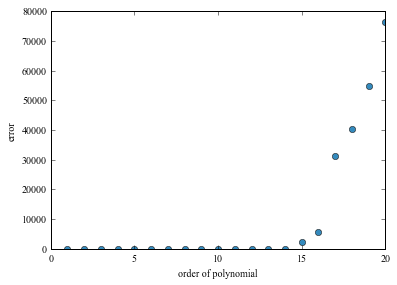

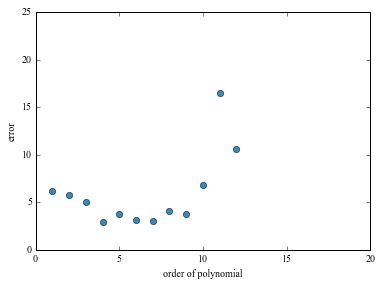

In [19]:
div = 10  # we will divide our data into div segments
ndata = 20  # number of data points
arrlength = ndata/div  # each segment should contain this much data
idxrand = np.random.permutation(n)  # random index into data from 0 ... n

error = np.zeros(len(ordervec))

# iterate through polynomial orders
for i, order in enumerate(ordervec):
    
    # iterate through divisions of data for k-holdout
    for j in range(div):
        
        # indicies of data to leave out from the random permutations
        holdout = idxrand[arrlength*j:arrlength*(j+1)]
    
        # separaet into training set and testing set
        xtrain = np.delete(xdata, holdout)
        ftrain = np.delete(fdata, holdout)
        xtest = xdata[holdout]
        ftest = fdata[holdout]
           
        # build a polynomial model from the training data 
        w = createpoly(xtrain, ftrain, order)

        # test the error with the validation set
        fhat = evalpoly(xtest, w)
        error[i] += np.linalg.norm(fhat - ftest) / div  # average error across divisions
        

# plot error
plt.figure()
plt.plot(ordervec, error, 'o')
plt.xlabel('order of polynomial')
plt.ylabel('error')
plt.show()

# plot error
plt.figure()
plt.plot(ordervec, error, 'o')
plt.xlabel('order of polynomial')
plt.ylabel('error')
plt.ylim([0, 25])
plt.show()



Both plots are the same, but the axis is smaller on the bottom one because the error blows up quickly.  Notice that now, instead of the error continualy decreasing, it decreases for a while then increases as we run into problems with overfitting.  Generally, we like to choose the simplest model that gives reasonable error.  The curve is pretty flat near the minimum, and in this case a good point is somewhere around a 4th order polynomial.

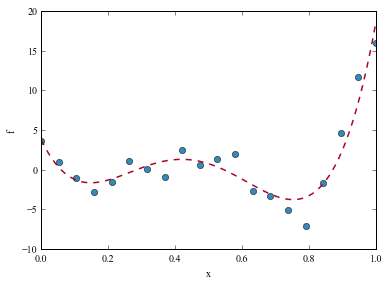

In [20]:
order = 4
w = createpoly(xdata, fdata, order)

nhat = 200
xhat = np.linspace(0, 1, nhat)
fhat = evalpoly(xhat, w)

plt.figure()
plt.plot(xdata, fdata, 'o')
plt.plot(xhat, fhat, '--')
plt.ylim([-10, 20])
plt.xlabel('x')
plt.ylabel('f')

We can see that this results in a much predictive model than the 20th order polynomial.